In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats 
from windrose import WindroseAxes

In [73]:
df = pd.read_csv("../src/data/benin-malanville.csv")


Staticstics summary

In [ ]:

print(df.describe()) # for numerical date 

# print(df.describe(include=['object'])) # for categorical column 

# print(df.isna()) # presents nan value as true and false for non-nan 

print(df.info())


# check for missing values 
print(df.isna().sum()) 

# Column to check
numeric_cols = df.select_dtypes(include='number').columns

# Plot histogram
df[numeric_cols].hist(bins=50, figsize=(16, 12), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of All Numeric Columns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Outlier Detection & Basic Cleaning


📊 Column: ModA
 - Q1: 0.00
 - Q3: 463.70
 - IQR: 463.70
 - Lower Bound: -1391.10
 - Upper Bound: 1854.80
 - Outliers found: 0

📊 Column: ModB
 - Q1: 0.00
 - Q3: 447.90
 - IQR: 447.90
 - Lower Bound: -1343.70
 - Upper Bound: 1791.60
 - Outliers found: 0

📊 Column: WS
 - Q1: 1.00
 - Q3: 3.10
 - IQR: 2.10
 - Lower Bound: -5.30
 - Upper Bound: 9.40
 - Outliers found: 618

📊 Column: WSgust
 - Q1: 1.30
 - Q3: 4.10
 - IQR: 2.80
 - Lower Bound: -7.10
 - Upper Bound: 12.50
 - Outliers found: 638


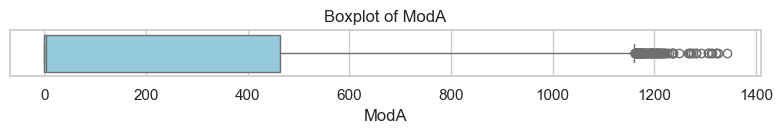

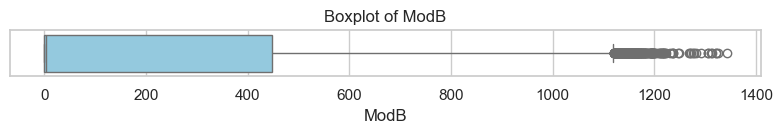

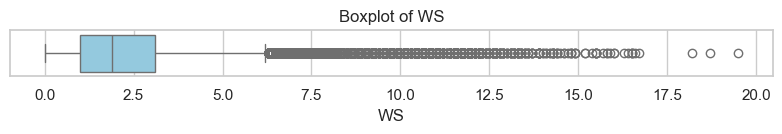

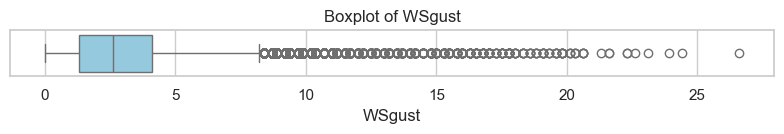

In [74]:
# Define the columns to check for outliers
columns_to_check = ['ModA', 'ModB', 'WS', 'WSgust']

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Find outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = len(outliers)

        print(f"\n📊 Column: {col}")
        print(f" - Q1: {Q1:.2f}")
        print(f" - Q3: {Q3:.2f}")
        print(f" - IQR: {IQR:.2f}")
        print(f" - Lower Bound: {lower_bound:.2f}")
        print(f" - Upper Bound: {upper_bound:.2f}")
        print(f" - Outliers found: {len(outliers)}")

    return outlier_counts

# Call  function
outlier_summary = detect_outliers_iqr(df, columns_to_check)

# Boxplot Visualization
for col in columns_to_check:
    plt.figure(figsize=(8, 1.5))  # Wide and short for horizontal boxplot
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Z-scores detection & Impute with median for outliers 

In [75]:
# Columns to analyze
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

#  Compute Z-scores 
z_scores = stats.zscore(df[columns_to_check], nan_policy='omit')  # Handles NaN gracefully

# Convert to DataFrame to make it easier to work with
z_scores_df = pd.DataFrame(z_scores, columns=columns_to_check)

#  Identify where |Z| > 3
z_outliers = (np.abs(z_scores_df) > 3)

#  Add a flag column to original df
df['Z_Outlier_Flag'] = z_outliers.any(axis=1)

#  Filter rows where at least one column is an outlier
outlier_rows = df[df['Z_Outlier_Flag']]

print(f"\n🚩 Rows with Z-score > 3 in any target column: {len(outlier_rows)}")
print(outlier_rows[columns_to_check + ['Z_Outlier_Flag']].head())

#  Replace outlier values with NaN
for col in columns_to_check:
    df[col] = df[col].mask(z_outliers[col], np.nan)

#  Impute those NaNs with median
for col in columns_to_check:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# ✅ Confirm imputation
print("\n✅ After imputation (Z-score outliers replaced with median):")
print(df[columns_to_check].describe())
print(df[columns_to_check].head())


🚩 Rows with Z-score > 3 in any target column: 7740
        GHI    DNI    DHI    ModA    ModB   WS  WSgust  Z_Outlier_Flag
670   836.0  235.0  610.6   778.8   783.8  3.2     4.1            True
671  1274.0  698.8  615.2  1210.3  1210.3  3.4     4.1            True
672   938.0  340.1  612.8   891.1   891.1  3.4     4.6            True
673   718.5  126.8  593.2   682.6   682.6  4.7     5.6            True
674  1349.0  771.8  618.0  1281.5  1281.5  4.0     4.6            True

✅ After imputation (Z-score outliers replaced with median):
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.342811     167.187516     110.899160     236.524528   
std       330.868308     261.710501     152.922463     326.815176   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       0.500

In [ ]:
output_file_path = "../src/data/benin_cleaned_data.csv" # save cleaned data 
df.to_csv(output_file_path, index=False)  

print(f"\n📂 Cleaned dataset saved to: {output_file_path}")

Time Series Analysis

C:\Users\mijuu\AppData\Local\Temp\ipykernel_9176\499537873.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mijuu\Documents\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


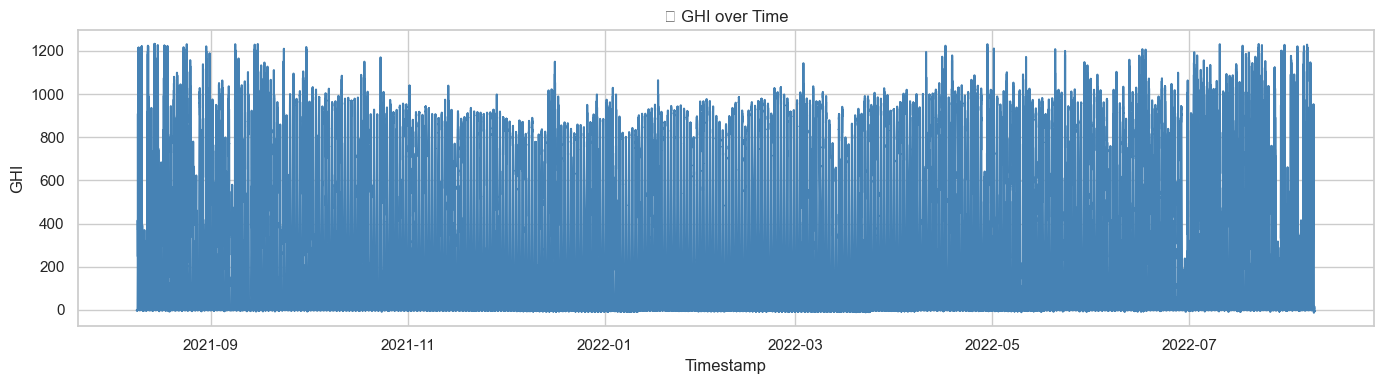

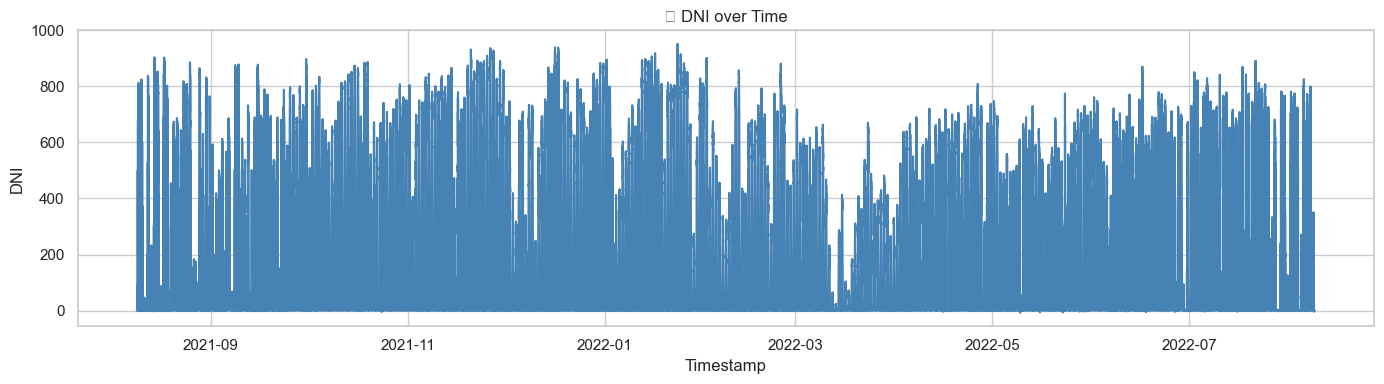

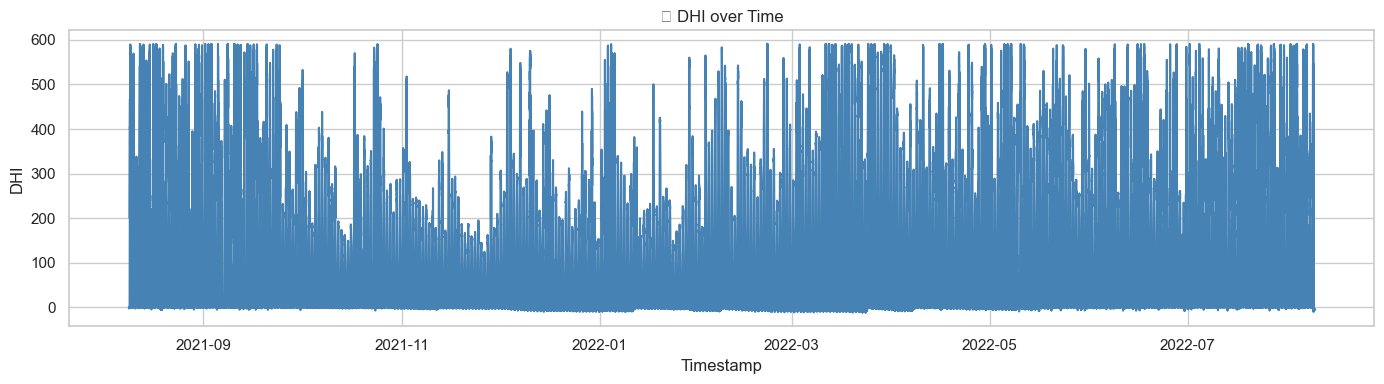

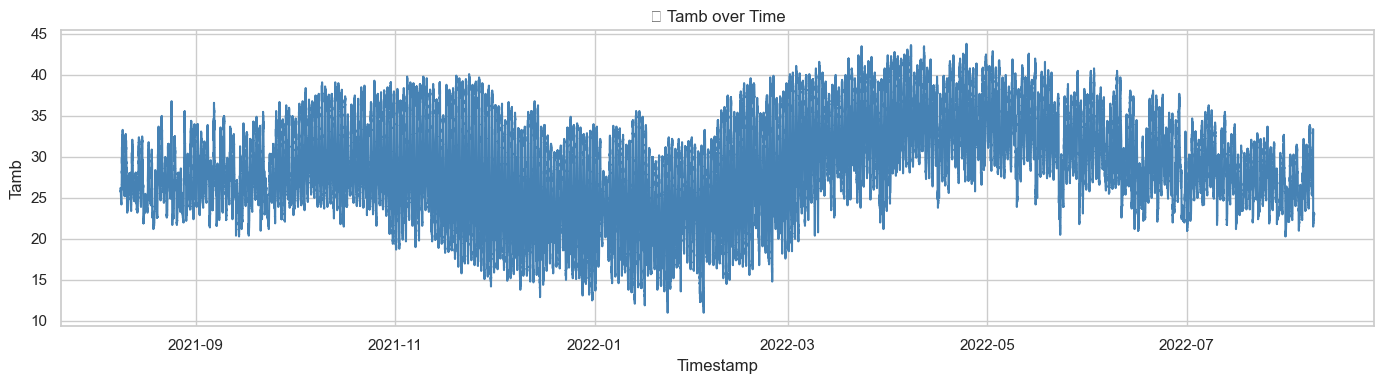

In [ ]:

# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as the index for time series plotting
df.set_index('Timestamp', inplace=True)

# List of columns to plot
columns_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

# Set plot style
sns.set(style="whitegrid")

# Folder name to save image 
folder_path = '../screenshots/benin' 

# Plot each column in a separate figure
for col in columns_to_plot:
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[col], label=col, color='steelblue')
    plt.title(f'📈 {col} over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Save the plot
    filename = os.path.join(output_dir, f"{col}_timeseries.png")
    plt.savefig(filename)
    plt.close()  # Close the figure to avoid memory issues

 

In [ ]:
# Group by month from Timestamp index
monthly_avg = df.groupby(df.index.month)[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Rename month numbers to names
monthly_avg.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
monthly_avg.plot(figsize=(12, 6), marker='o')
plt.title('📆 Monthly Average of Solar Irradiance & Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Group by hour of the day from Timestamp
hourly_avg = df.groupby(df.index.hour)[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Plot
hourly_avg.plot(figsize=(12, 6), marker='o')
plt.title('🕒 Hourly Average of Solar Irradiance & Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()

Cleaning impact 

In [ ]:
# Group by Cleaning flag and compute mean of ModA and ModB
mod_avg_by_cleaning = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plotting
mod_avg_by_cleaning.plot(kind='bar', figsize=(8, 5), rot=0)
plt.title('🔧 Average ModA and ModB - Pre vs Post Cleaning')
plt.xlabel('Cleaning Flag (0 = Before, 1 = After)')
plt.ylabel('Average Sensor Output')
plt.legend(title='Sensor')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Correlation & Relationship Analysis

In [ ]:
# Select relevant columns
columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("🔍 Correlation Heatmap of Solar & Module Temperatures")
plt.tight_layout()
plt.show()

In [ ]:
# Set style
sns.set(style="whitegrid")

# Define pairs to plot
scatter_pairs = [
    ('WS', 'GHI'),    # Wind speed effect on irradiance
    ('WSgust', 'GHI'), # Gusty wind and cloud movement
    ('WD', 'GHI'), # Wind direction’s influence
    ('RH', 'Tamb'), #Humidity vs. temperature
    ('RH', 'GHI') # Humidity vs. solar availability
]

# Plot each scatter pair
for x_var, y_var in scatter_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=x_var, y=y_var, alpha=0.4, color='teal')
    plt.title(f'📈 {y_var} vs. {x_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.tight_layout()
    plt.show()

Wind & Distribution Analysis

In [ ]:
# Clean any missing values for WS or WD
df_clean = df[['WS', 'WD']].dropna()

# Create Windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('🧭 Wind Rose: Wind Speed vs. Wind Direction')
ax.set_legend()
plt.show()

Temperature Analysis

In [ ]:
scatter_pairs = [
    ('RH', 'Tamb'),
    ('RH', 'TModA'),
    ('RH', 'GHI'),
    ('RH', 'DNI')
]

for x, y in scatter_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.4)
    plt.title(f'{y} vs. {x}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

# Finding : higher Ambient Temperature is associated with lower Relative Humidity

Bubble Chart


In [ ]:
df_bubble = df[['GHI', 'Tamb', 'RH']].dropna()

# Create the bubble chart
plt.figure(figsize=(10, 6))
plt.scatter(df_bubble['GHI'], df_bubble['Tamb'], 
            s=df_bubble['RH'],  # bubble size
            alpha=0.5, c='steelblue', edgecolors='w')

plt.title('🌡️ GHI vs. Tamb (Bubble Size = RH)')
plt.xlabel('GHI (Global Horizontal Irradiance)')
plt.ylabel('Tamb (Ambient Temperature)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Finding: Relative humidity is highest when GHI and Tamb are moderate.